In [1]:
import pandas as pd
import numpy as np

from datasets import Dataset

In [2]:
fx = pd.read_csv('data/OANDA/EUR_USD.csv')

fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)

In [3]:
fx.duplicated(subset = 'datetime').any()

False

# Preprocessing

- Step 1: linearly interpolate gaps (shoot, not sure how to do this in parallel besides filling in all gaps and then getting rid of friday -> sunday
- Step 2: so we will go from 21:00 to 21:00 from sunday to friday
    - make a "trading day" feature starting from 21:00 of 
    - get rid of stragler days with no trades at end and beginning if the don't match up right
- Step 3: subtract the day's open at 21:00 from each day (group by day easy) -- let's not honestly...
- Step 4: make relative volume indicator using comparing real volume to groupby day's MA -- yeah I mean for now let's not
- Step 5: 60min HLC

- Step 6: create train, validation and test datasets
- Step 7: divide each column by their std (ungrouped) USING ONLY TRAINING SET MAKING SURE TO SAVE THIS NUMBER -- not for now


Make JSON:
- make the weekday and relative volume a feature
- make inputs_embeds a 2d array containing OHLCV and label 2D array of HLC (no day of week)
- store as JSON

In [4]:
# Linearly interpolate time gaps
fx = fx.set_index('datetime').asfreq('1min')
fx['close'] = fx['close'].fillna(method = 'ffill')
fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

# fill open high and low with most recent close
fx = fx.fillna({
    'open': fx['close'],
    'high': fx['close'],
    'low': fx['close']
})

In [5]:
# define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
fx['day'] = fx.index.dayofweek 
fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

# ordinal trading day since start of data (just for help in preprocessing)
fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()

<AxesSubplot:>

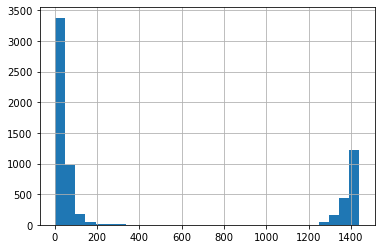

In [6]:
# look at distribution of how many 0 volume minute
(fx['volume'] == 0.).groupby(fx['ordinal_day']).sum().hist(bins = 30)

In [7]:
# let's just arbitrary say there should be less than 100 zero volume -- shouldn't really mattter in the end
voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 200).index
fx = fx.loc[voluminous_index]

In [8]:
# quick sanity check of data 
fx.between_time('20:59', '21:01')

,close,high,low,open,volume,day,ordinal_day
datetime,,,,,,,
2005-01-02 20:59:00,1.35410,1.35480,1.35410,1.35480,2.0,6,1
2005-01-02 21:00:00,1.35410,1.35410,1.35410,1.35410,0.0,0,2
2005-01-02 21:01:00,1.35400,1.35400,1.35400,1.35400,1.0,0,2
2005-01-03 20:59:00,1.34690,1.34700,1.34680,1.34690,19.0,0,2
2005-01-03 21:00:00,1.34700,1.34700,1.34690,1.34690,30.0,1,3
...,...,...,...,...,...,...,...
2022-10-30 21:00:00,0.99642,0.99642,0.99642,0.99642,0.0,0,6512
2022-10-30 21:01:00,0.99642,0.99642,0.99642,0.99642,0.0,0,6512
2022-10-31 20:59:00,0.98819,0.98819,0.98819,0.98819,0.0,0,6512


# All data

In [1]:
import os
import pandas as pd
import numpy as np

import datasets
from datasets import Dataset, concatenate_datasets

# Start with processing all CSVs to datasets

In [2]:
def make_dataset(filename, periods = [1, 2, 3, 4, 5, 10, 15, 20, 30, 45, 60, 90, 120]):
    fx = pd.read_csv(filename)

    fx['datetime'] = pd.to_datetime(fx['datetime'], infer_datetime_format = True)
    
    # Linearly interpolate time gaps
    fx = fx.set_index('datetime').asfreq('1min')
    fx['close'] = fx['close'].fillna(method = 'ffill')
    fx['volume'] = fx['volume'].fillna(0) # no volume in gaps (according to first rate data people)

    # fill open high and low with most recent close
    fx = fx.fillna({
        'open': fx['close'],
        'high': fx['close'],
        'low': fx['close']
    })
    
    # define the "trading day" as from starting on 9pm UTC of the previous day ending at 8:59pm UTC
    fx['day'] = fx.index.dayofweek 
    fx.loc[fx.between_time('21:00', '23:59').index, 'day'] += 1
    fx['day'] = fx['day'] % 7 # sunday = 6, then + 1 would be 7 but we want that roll over to monday = 0

    # ordinal trading day since start of data (just for help in preprocessing)
    fx['ordinal_day'] = (fx['day'] != fx['day'].shift()).cumsum()
    
    # let's just arbitrary say there should be less than 200 zero volume -- shouldn't really mattter in the end
    voluminous_index = (fx['volume'] == 0.).groupby(fx['ordinal_day']).filter(lambda x: x.sum() < 200).index
    fx = fx.loc[voluminous_index]

    futures = {}
    for i in periods:
        col_name = f'future_close{i}'
        futures[col_name]  = fx['close'].shift(-i) - fx['close']
    futures_df = pd.DataFrame(futures)
    future_cols = futures_df.columns

    fx = pd.concat((fx, futures_df), axis = 1)
    
    # clean up data odditity of future columns coming from the future of non-consecutive days (i.e. no overnight trading)
    fx['day_break'] = ((fx['day'] != (fx['day']).shift(-1)) & (fx['day'] != (fx['day'] - 1).shift(-1)))
    no_futures = fx[fx.groupby('ordinal_day')['day_break'].transform('any')].between_time(f'{20 - max(periods) // 60}:{59 - max(periods) % 60}', '20:59').index
    fx.loc[no_futures, future_cols] = 0
    
    # de mean prices by considering their differences
    fx['day_close'] = fx['close'].sub(fx.groupby('ordinal_day')['close'].transform('first'), axis = 0)
    fx[['open', 'high', 'low']] = fx[['open', 'high', 'low']].sub(fx['close'], axis = 0)
    fx['close_diff'] = fx['close'] - fx['close'].shift(1)
    
    # de mean close and volume using previous day's mean
    fx['close'] = fx.groupby('ordinal_day')['close'].transform('mean').shift(1440)
    fx['volume'] = fx.groupby('ordinal_day')['volume'].transform('mean').shift(1440)
    
    features = ['open', 'high', 'low', 'close_diff', 'close', 'volume']
    
    # de standardize using the previous day's std
    stds = fx.groupby('ordinal_day')[features].transform('std').shift(1440)
    fx[features] = fx[features] / stds
        
    # get rid of first two days and last day due to data incompleteness
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].min()].index)
    fx = fx.drop(fx[fx['ordinal_day'] == fx['ordinal_day'].max()].index)
        
    ohlcv = fx[features].values.reshape(-1, 1440, 6)
    future = fx[future_cols].values.reshape(-1, 1440, len(periods))
    
    # save some memory
    del fx
    
    ds = Dataset.from_dict({"ohlcv": ohlcv, "future": future})
    
    return ds

In [3]:
data_dir = './data/OANDA/'
for file in os.listdir(data_dir):
    dataset = make_dataset(data_dir + file)
    dataset.save_to_disk(f"data/OANDA_DS/{file[:7]}.ds")
    print(file, end = '\r')

# Concat all datasets (done in 2 stages due to memory contraints)

In [4]:
data_dir = './data/OANDA_DS/'
os.listdir(data_dir)

['AUD_CAD.ds',
 'AUD_JPY.ds',
 'AUD_NZD.ds',
 'AUD_USD.ds',
 'EUR_AUD.ds',
 'EUR_CHF.ds',
 'EUR_GBP.ds',
 'EUR_JPY.ds',
 'EUR_NZD.ds',
 'EUR_USD.ds',
 'GBP_AUD.ds',
 'GBP_CAD.ds',
 'GBP_CHF.ds',
 'GBP_JPY.ds',
 'GBP_USD.ds',
 'NZD_JPY.ds',
 'NZD_USD.ds',
 'USD_CAD.ds',
 'USD_CHF.ds',
 'USD_JPY.ds']

In [5]:
# make eurusd the last dataset (as it will be the validation set)
filenames = [
    'AUD_CAD.ds',
    'AUD_JPY.ds',
    'AUD_NZD.ds',
    'AUD_USD.ds',
    'EUR_AUD.ds',
    'EUR_CHF.ds',
    'EUR_GBP.ds',
    'EUR_JPY.ds',
    'EUR_NZD.ds',
    'GBP_AUD.ds',
    'GBP_CAD.ds',
    'GBP_CHF.ds',
    'GBP_JPY.ds',
    'GBP_USD.ds',
    'NZD_JPY.ds',
    'NZD_USD.ds',
    'USD_CAD.ds',
    'USD_CHF.ds',
    'USD_JPY.ds',
    'EUR_USD.ds'
]

In [6]:
list_ds = [datasets.load_from_disk(data_dir + filename) for filename in filenames]

In [7]:
all_datasets = concatenate_datasets(list_ds)
all_datasets.save_to_disk("data/fx_days.ds")

OSError: [Errno 22] Invalid argument: 'C:/Users/micha/Desktop/Trader/data/fx_days.ds/dataset.arrow'

In [ ]:
datasets.load_from_disk("data/fx_days.ds")